# Segmenting and Clustering Neighborhood in Toronto 3/3
## Clustering

This is the third part of the capstone project. In previous parts I have collected a list of neighbourhoods of Toronto from a wiki webpage and assigned geolocation (latitude, longitude) to each of them.

In this last part I'm doing the actual clustering of the negihbourhoods based on the venues they can provide. I'm using the API of foursquare.com to get the recommended facilities.

In [1]:
import pandas as pd
import numpy as np
import folium
import foursquare
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

%matplotlib inline

I'm loading the csv file prepared at the end of previous part.

In [2]:
df_toronto=pd.read_csv('toronto_w_geocode.csv')
df_toronto.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.756123,-79.329636
1,M4A,North York,Victoria Village,43.726780,-79.310738
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.655354,-79.365044
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.721996,-79.445915
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.663910,-79.388733


In [3]:
df_toronto.shape

(94, 5)

I'm creating requests to foursquare.com to get all recommended facilities in each neighbourhood.

Unlike in the previous lab session I'm using [foresquare](https://github.com/mLewisLogic/foursquare) library instead of requests. This way I don't have to prepare long URLs all the time, the code is more readable. Also error handling and timeout management is implemented.

In [4]:
#IDs to be deleted before uploading to Git!
fq_client = foursquare.Foursquare(client_id='xxx',
                               client_secret='xxx')

In [5]:
def getNearbyVenues(client, names, latitudes, longitudes, radius=500, limit=100):
    '''Collecting recommended venues from multiple locations using Foursquare API.
    names, latitudes and longitudes are iterable objects (e.g. lists or series) of the same size.
    Returning DataFrame with all venues name, location and category'''
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        results=client.venues.explore(params={'ll':str(lat)+','+str(lng),'radius':radius,'limit':limit})
        results=results['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

I had a lot of consideration about the query radius. Originally I used the same radius (500 m) we had in the New York lab session. With that setting I got less than 5 recommended venues for almost 40% of the neighbourhoods.

The reason is simple if you look at the visualization in previous part. Downtown area is very crowded but small, an average neighbourhood is around 3-500 m diameter. Off-downtown districts are more bigger, around 1500-2500 m. I'm using a radius of 1000 m (from the center) to capture all venues within a neighbourhood. Of course there will be overlapping in downtown, but I think it's fine, it is not forbidden to use nearby facilities if it is in another neighbourhood.

In [6]:
df_venues=getNearbyVenues(fq_client,df_toronto['Neighbourhood'],df_toronto['Latitude'],df_toronto['Longitude'],radius=1000)

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
B

Let's analyse the list of venues.

In [7]:
print(df_venues.shape)
df_venues.head()

(4907, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.756123,-79.329636,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
1,Parkwoods,43.756123,-79.329636,Tim Hortons,43.760668,-79.326368,Café
2,Parkwoods,43.756123,-79.329636,Brookbanks Park,43.751976,-79.332140,Park
3,Parkwoods,43.756123,-79.329636,A&W,43.760643,-79.326865,Fast Food Restaurant
4,Parkwoods,43.756123,-79.329636,Shoppers Drug Mart,43.760857,-79.324961,Pharmacy


In [8]:
venue_count=df_venues.groupby('Neighborhood').count().sort_values(by='Venue',ascending=False)
venue_count

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Studio District,100,100,100,100,100,100
Davisville,100,100,100,100,100,100
Leaside,100,100,100,100,100,100
"Kensington Market, Chinatown, Grange Park",100,100,100,100,100,100
"Little Portugal, Trinity",100,100,100,100,100,100
...,...,...,...,...,...,...
"North Park, Maple Leaf Park, Upwood Park",9,9,9,9,9,9
"Humberlea, Emery",8,8,8,8,8,8
Humber Summit,5,5,5,5,5,5


It's quite as expected

Text(0.5, 0, 'No. of recommended venues')

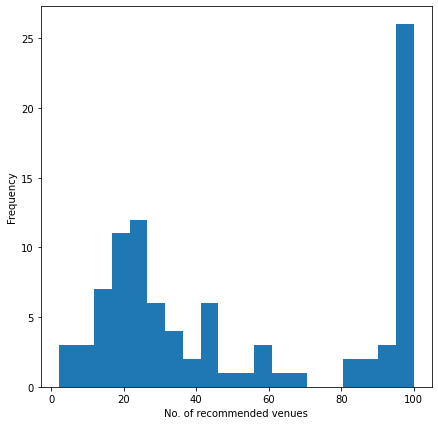

In [30]:
ax=venue_count['Venue'].plot(kind="hist",figsize=(7,7),bins=20)
ax.set_xlabel('No. of recommended venues')

In [10]:
len(df_venues['Venue Category'].unique())

338

There are 338 different venue categories in the list. Funfact: there is a category called "Neighborhood" (see below) which led to various mystical errors during one-hot encoding. 😋 

In the later part of the notebook I'm using Neighbo*u*rhood in column name as a description of the area to avoid errors, and left category name Neighborhood as it is.

In [11]:
df_venues[df_venues['Venue Category']=='Neighborhood']

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
476,"Garden District, Ryerson",43.657478,-79.378632,Downtown Toronto,43.653232,-79.385296,Neighborhood
725,St. James Town,43.651112,-79.375732,Downtown Toronto,43.653232,-79.385296,Neighborhood
863,The Beaches,43.676559,-79.294159,Upper Beaches,43.680563,-79.292869,Neighborhood
1138,Central Bay Street,43.656761,-79.386490,Downtown Toronto,43.653232,-79.385296,Neighborhood
1457,"Richmond, Adelaide, King",43.649670,-79.382248,Downtown Toronto,43.653232,-79.385296,Neighborhood
1802,"Harbourfront East, Union Station, Toronto Islands",43.640686,-79.376625,Harbourfront,43.639526,-79.380688,Neighborhood
2222,"Brockton, Parkdale Village, Exhibition Place",43.640915,-79.429573,Parkdale,43.640524,-79.432200,Neighborhood
2479,Studio District,43.661816,-79.342186,Leslieville,43.662070,-79.337856,Neighborhood
2806,Lawrence Park,43.727158,-79.397041,Bedford Park,43.725188,-79.408463,Neighborhood
3559,Canada Post Gateway Processing Centre,43.651894,-79.381714,Downtown Toronto,43.653232,-79.385296,Neighborhood


The last stage of the data preparation is to get the features that can be fed into a learning algorithm. I'm using Pandas built-in function get_dummies to make one-hot encoding. After that I'm counting the number of venues in each category in Neighbourhoods. This will be the measurement of similarity.

In the lab session mean value was used instead of sum which I don't really understand. Let's take two neighbourhoods with 10-10 cafés in both area. But in the first neighbourhood we got other 10 recommendations (hotels, banks, bakeries, etc.) while in the other we got 90 others. In the first case the mean value of cafes will be 50% while it is 10% in the other area. Can we say that cafes are "less frequent" in the second area? No. So, I'm using sum of values.

I'm still wondering if normalizaton is needed in this case or not. My guess is no, as all features have the same "unit of measure".

In [12]:
toronto_onehot =pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot['Neighbourhood'] = df_venues['Neighborhood'] 

#reordering columns:
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

print(toronto_onehot.shape)
toronto_onehot.head()

(4907, 339)


,Neighbourhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Argentinian Restaurant,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').sum().reset_index()
toronto_grouped

,Neighbourhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Argentinian Restaurant,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,"Alderwood, Long Branch",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,"Bathurst Manor, Wilson Heights, Downsview North",0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bayview Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,"Bedford Park, Lawrence Manor East",0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,"Willowdale, Willowdale West",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
90,Woburn,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
91,Woodbine Heights,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
92,York Mills West,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we can use the feature set for k-means clustering.

I have been considering the number of clusters. I tried the algorithm with different numbers, and I found that the results were the most meaningful between 4-6 clusters. So I'm using 5 clusters now:

In [14]:
n_clusters=5
toronto_clusters=KMeans(n_clusters,random_state=42)
clusters=toronto_clusters.fit(toronto_grouped.drop('Neighbourhood',axis=1))
print(clusters.labels_)

[0 2 0 2 2 3 0 4 3 0 3 0 3 4 1 0 0 1 1 0 2 0 0 4 1 0 2 2 3 0 0 0 3 4 0 0 0
 0 2 0 0 4 0 2 2 1 4 0 0 2 2 0 0 1 0 0 0 1 0 0 1 3 3 1 0 0 1 2 0 0 3 2 0 4
 1 1 2 1 2 0 3 0 0 0 0 0 0 2 1 0 0 2 2 0]


I'm merging the cluster data with locations for visualization

In [15]:
toronto_merged=df_toronto.sort_values('Neighbourhood')
toronto_merged['Cluster']=clusters.labels_
toronto_merged.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster
72,M1S,Scarborough,Agincourt,43.793564,-79.267647,0
86,M8W,Etobicoke,"Alderwood, Long Branch",43.599304,-79.536049,2
27,M3H,North York,"Bathurst Manor, Wilson Heights, Downsview North",43.750977,-79.447235,0
38,M2K,North York,Bayview Village,43.773895,-79.379799,2
50,M5M,North York,"Bedford Park, Lawrence Manor East",43.731823,-79.417870,2


In [16]:
toronto_merged['Cluster'].value_counts(sort=False)

0    45
1    14
2    18
3    10
4     7
Name: Cluster, dtype: int64

In [17]:
# create map
map_clusters = folium.Map(location=[43.7, -79.3], zoom_start=11)

# set color scheme for the clusters
x = np.arange(n_clusters)
ys = [i + x + (i*x)**2 for i in range(n_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The last part of the notebook is about finding some meanings of the clusters, i.e. looking at the main properties of the clusters and giving some textual evaluation of the results.

For this I'm calculating the average number of venues of the same categories by neighbourhoods of the same cluster and looking at the top 5 categories:

In [18]:
toronto_merged=toronto_merged.merge(toronto_grouped)
toronto_merged.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster,Accessories Store,Afghan Restaurant,African Restaurant,Airport,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,M1S,Scarborough,Agincourt,43.793564,-79.267647,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,M8W,Etobicoke,"Alderwood, Long Branch",43.599304,-79.536049,2,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,M3H,North York,"Bathurst Manor, Wilson Heights, Downsview North",43.750977,-79.447235,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M2K,North York,Bayview Village,43.773895,-79.379799,2,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,M5M,North York,"Bedford Park, Lawrence Manor East",43.731823,-79.417870,2,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [19]:
venue_mean=toronto_merged.groupby('Cluster').mean().drop(['Latitude','Longitude'],axis=1).reset_index()
venue_mean=pd.concat([venue_mean,toronto_merged[['Cluster','Neighbourhood']].groupby('Cluster').count()],axis=1)
venue_mean.head()

,Cluster,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Argentinian Restaurant,...,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Neighbourhood
0,0,0.000000,0.044444,0.022222,0.022222,0.066667,0.0,0.000000,0.0,0.022222,...,0.000000,0.177778,0.022222,0.000000,0.000000,0.022222,0.022222,0.022222,0.022222,45
1,1,0.000000,0.214286,0.000000,0.000000,0.857143,0.0,0.071429,0.0,0.000000,...,0.142857,0.571429,0.000000,0.000000,0.285714,0.000000,0.142857,0.071429,1.071429,14
2,2,0.000000,0.000000,0.000000,0.000000,0.333333,0.0,0.000000,0.0,0.000000,...,0.055556,0.055556,0.000000,0.000000,0.055556,0.000000,0.222222,0.166667,0.166667,18
3,3,0.000000,0.000000,0.000000,0.000000,1.200000,0.1,0.000000,0.3,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.900000,10
4,4,0.142857,0.000000,0.285714,0.000000,0.857143,0.0,0.428571,0.0,0.000000,...,0.000000,1.857143,0.000000,0.142857,0.714286,0.000000,0.000000,0.000000,1.142857,7


In [27]:
def most_frequent(row):
    no_of_top_cats=5
    print('Cluster: ',int(row[0]),' Neighbours count: ',int(row[-1]))
    print(row[1:-2].sort_values(ascending=False)[1:no_of_top_cats+1])
    print('\n')

In [28]:
print('Most frequent venues per Cluster:\n')
_=venue_mean.apply(most_frequent,axis=1)

Most frequent venues per Cluster:

Cluster:  0  Neighbours count:  45
Pizza Place             1.377778
Park                    1.044444
Pharmacy                0.777778
Chinese Restaurant      0.711111
Fast Food Restaurant    0.711111
Name: 0, dtype: float64


Cluster:  1  Neighbours count:  14
Café                  4.214286
Italian Restaurant    4.000000
Restaurant            3.142857
Sushi Restaurant      2.500000
Pizza Place           2.500000
Name: 1, dtype: float64


Cluster:  2  Neighbours count:  18
Park           2.166667
Restaurant     1.611111
Café           1.555556
Pizza Place    1.388889
Bank           1.277778
Name: 2, dtype: float64


Cluster:  3  Neighbours count:  10
Café                   5.3
Restaurant             4.3
Hotel                  3.6
Japanese Restaurant    3.1
Italian Restaurant     2.9
Name: 3, dtype: float64


Cluster:  4  Neighbours count:  7
Bar                              5.714286
Coffee Shop                      5.571429
Bakery                      

Based on the data the clusters have the following properties:
- Cluster 0: Suburban or low density residential neighbourhoods with very few venues but more green area (Parks are no 2. venues!)
- Cluster 1: Downtown area with mostly restaurants. I guess these are probably commercial zones with offices.
- Cluster 2: Similar to Cluster 0 so it is most probably a residential area but with more frequent facilities. My guess is that these zones are closer to main roads or train lines.
- Cluster 3: Hotel frequency is no. 3 in these areas. Most probably these are tourist zones.
- Cluster 4: Bars, restaurants and coffee shops. My guess that these are leisure zones with high night life.

*That concludes my project. I hope you enjoyed reviewing it as much as I enjoyed preparing!*